# **PyTorch CNN to classify between sphere and ellipsoid cluster systems**

## 1. Imporing PyTorch and setting up device-agnostic code

In [1]:
#creating responsive plot
%matplotlib widget

# Import packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

# Import torchvision
import torch
import torch.nn as nn
import torchvision 
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim

# Check version
print(torch.__version__)
print(torchvision.__version__)

2.2.2
0.17.2


In [221]:
# setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
np.random.seed(42)

NVIDIA GeForce RTX 2070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB


## 2. Functions and classes

In [4]:
# Generate uniform points on surface of sphere for normal projections
def projection_points(radius, num_points):
    
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)
    
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    
    
    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

""" Functions that are used to generate filled sphere and
elipsoid"""

# Generate points on surface of sphere
def sphere(radius, num_points, plot=False):
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points) * radius)
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)

    if plot:
        # Plot Structure
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection='3d')
        plt.gca().set_aspect('auto', adjustable='box')
        ax.scatter(x,y,z, marker='.')
        ax.set_aspect('equal', 'box') #auto adjust limits
        #ax.axis('equal')
        ax.set_title('Structure of Circle', fontsize=10)
        plt.show()

    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

# Generate points on surface of sphere
def ellipsoid(radius, num_points, plot=False):
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points))
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    x = 1.5* r * np.sin(phi) * np.cos(theta)
    y = 1.1* r * np.sin(phi) * np.sin(theta)
    z = 0.8* r * np.cos(phi)

    if plot:
        # Plot Structure
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection='3d')
        #plt.gca().set_aspect('auto', adjustable='box')
        ax.scatter(x,y,z, marker='.')
        #ax.set_aspect('equal', 'box') #auto adjust limits
        ax.axis('equal')
        ax.set_title('Structure of Eplisoid', fontsize=10)
        plt.show()

    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

def points_projection(structure_coords, num_points):
    """ 
    Functions for projection
    """
    # Assign structure coords into z
    z = structure_coords
    
    # normal vectors generation
    normal = projection_points(1, num_points)

    all_projected_points = []
    for n in normal:
        #Find two orthogonal vectors u and v (both orthogonal to n)
        #Calc value for t (random vector), ensuring not a scaled version of n
        if n[0] != 0:
            t = np.array([-(n[1]+n[2]) / n[0], 1, 1])
        elif n[1] != 0:
            t = np.array([-(n[0]+n[2]) / n[1], 1, 1])
        else:
            t = np.array([-(n[0]+n[1]) / n[2], 1, 1])
        
        u = np.cross(t,n)
        v = np.cross(n,u)
        
        # Normalize u and v (vector length become 1 unit long)
        u = u / np.linalg.norm(u)
        v = v / np.linalg.norm(v)
        
        vec_mat = np.array([u,v])
        
        #Project structure points onto plane
        #Individual component of normal
        a = n[0]
        b = n[1]
        c = n[2]
        #d = 0 #component of equation of planes

        projected_points = []
        for point in z:
            z1, z2, z3 = point
            
            k = (0 - a*z1 - b*z2 - c*z3) / (a**2 + b**2 + c**2) 
            
            p1 = z1 + k*a
            p2 = z2 + k*b
            p3 = z3 + k*c
            
            p = np.array([p1,p2,p3])

            #Convert 3D points to 2D
            p_trans = p.transpose()
            proj_2d = np.dot(vec_mat,p_trans)
            projected_points.append(proj_2d)
            
        all_projected_points.append(projected_points)

    return np.array(all_projected_points)


def cluster_per_cell(projected_points, image_size, grid_size):
    '''
    Functiom that transforms projections into grid and no of points
    '''
    all_projections = np.array(projected_points)
    image_size = image_size
    grid_x = grid_size[0]
    grid_y = grid_size[1]
    
    #Calc size of grid cell
    cell_x = image_size[0] / grid_x
    cell_y = image_size[1] / grid_y

    all_grid = []
    for projection in all_projections:
        grid = np.zeros((grid_x,grid_y), dtype=int)
        
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projection, axis=0)
        max_val = np.max(projection, axis=0)
        
        #Feature scaling 
        points_norm = (projection - min_val) / (max_val - min_val) 
        
        scaled_points = (points_norm * (np.array(image_size) - 1)).astype(int)
        
        for points in scaled_points:
            x,y = points
            gridx_index = int(x // cell_x) #floor division followed by conversion to integer
            gridy_index = int(y // cell_y)
            grid[gridy_index, gridx_index] += 1
            
        all_grid.append(grid)
        
    # transform into bw image 
    all_images = []
    for grid_img in all_grid:
        min = np.min(grid_img)
        max = np.max(grid_img)
        points_norm = (grid_img - min) / (max - min) 
        all_images.append(points_norm)

    return  all_images


def image_projection(coords, size):
    '''
    # Transform projected points into image with 1s and 0s
    '''
    all_projects = np.array(coords)
    image_size = size

    all_images = []
    for projects in all_projects:
        
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projects, axis=0)
        max_val = np.max(projects, axis=0)
        
        #Feature scaling 
        points_norm = (projects - min_val) / (max_val - min_val) 
        
        # Scale points to image size
        points_scaled = (points_norm * (np.array(image_size) -1 )).astype(int)
        
        # Create an empty image
        image = np.zeros(image_size)
        
        # Populate the image with points
        for point in points_scaled:
            x, y = point
            image[y,x] = 1  # Note: (y, x) because image coordinates are row-major
        
        all_images.append(image)
    
    return all_images

In [6]:
#Function that makes labels
def label_making(label_num, lst):
    label = [label_num] * len(lst)
    return label

# Function that randomoly removes points in the strucutre
def points_remover(structure_coords, percentage):
    length = len(structure_coords)
    SIZES = length * percentage //100
    indexes = sorted(np.random.choice(length, size=SIZES, replace=False), reverse=True)

    mask = np.ones(len(structure_coords), dtype=bool)
    mask[indexes] = False

    new_structure = structure_coords[mask,...]

    return new_structure


def rotation(structure):
    point_cloud = structure
    
    # Convert to homogeneous coordinates
    point_cloud_homogeneous = []
    for point in structure:
        point_homogeneous = np.append(point,1)
        point_cloud_homogeneous.append(point_homogeneous)
    
    # Define the translation
    # tx, ty, tz = trans_matrix
    
    # # Construct the translation matrix
    # if reflection:
    #     translation_matrix = np.array([
    #     [-1, 0, 0, 0],
    #     [0, 1, 0, 0],
    #     [0, 0, -1, 0],
    #     [tx, ty, tz, 1],
    #     ])
    # else:
    #     translation_matrix = np.array([
    #     [1, 0, 0, 0],
    #     [0, 1, 0, 0],
    #     [0, 0, 1, 0],
    #     [tx, ty, tz, 1],
    #     ])

    x, y, z= np.random.uniform(low = 0, high = 2*np.pi, size=3)
    
    cx, sx = np.cos(x), np.sin(x)
    cy, sy = np.cos(y), np.sin(y)
    cz, sz = np.cos(z), np.sin(z)
    
    rotate_x = np.array([
        [1, 0, 0, 0],
        [0, cx, -sx, 0],
        [0, sx, cx, 0],
        [0, 0, 0, 1],
        ])

    rotate_y = np.array([
        [cy, 0, sy, 0],
        [0, 1, 0, 0],
        [-sy, 0, cy, 0],
        [0, 0, 0, 1],
        ])

    rotate_z = np.array([
        [cy, -sy, 0, 0],
        [-sy, cy, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        ])

    # Rotate in a 3 axis
    rotated_points = np.matmul(
        point_cloud_homogeneous,
        rotate_x)
    
    rotated_points = np.matmul(
        rotated_points,
        rotate_y)
    
    rotated_points = np.matmul(
        rotated_points,
        rotate_z)
    
    # Convert to cartesian coordinates
    rotated_points_xyz = []
    for point in rotated_points:
        point = np.array(point[:-1])
        rotated_points_xyz.append(point)
    '''
    # Uncomment to map original to translated points
    for i in range(len(point_cloud)):
        point = point_cloud[i]
        translated_point = translated_points_xyz[i]
        print(f'{point} → {list(translated_point)}')
    '''
    return np.array(rotated_points_xyz)

def plot_structure(structure):

    x = structure[:,0]
    y = structure[:,1]
    z = structure[:,2]
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(projection='3d')
    plt.gca().set_aspect('auto', adjustable='box')
    ax.scatter(x,y,z, marker='.')
    #ax.set_aspect('equal', 'box') #auto adjust limits
    ax.axis('equal')
    # ax.set_xlim(11)
    # ax.set_ylim(11)
    # ax.set_zlim(11)
    ax.set_title('3D plot of structure', fontsize=10)
    plt.show()
    return

# makes spherical systems
def system_maker(no_of_systems ,max_spheres, max_sphere_size, no_of_points, no_of_projections, image_res):
    system_store = []
    for i in range(no_of_systems):
        
        systems = []
        no_of_spheres = np.random.randint(2,max_spheres) # min 2 sphere per system
        #no_of_spheres = max_spheres
        for n in range(no_of_spheres):
            a = sphere(max_sphere_size, no_of_points) # create sphere
            a = a + (np.random.rand(1,3) * np.random.randint(11)) # translate sphere around
            systems.append(a) # add spheres
            
        systems = np.array(systems) #transform into numpy array
        systems = systems.reshape(-1 , systems.shape[-1]) # reshape so that spheres coordinates in each systems combines
        system_store.append(systems) 
        
    #system_store = np.array(system_store)

    # Project 3D system onto 2D plane
    proj_2D_all = []
    for system in system_store:
        proj_2D = points_projection(system,no_of_projections)
        proj_2D_all.append(proj_2D)

    # Transform projecteed 2D points into black and white images (values are 0 or 1)
    bw_img_all = []
    for proj in proj_2D_all:
        image = image_projection(proj, image_res)
        bw_img_all.append(image)
        
    bw_img_all = np.array(bw_img_all)
    bw_img_all = bw_img_all.reshape(-1,bw_img_all.shape[-2],bw_img_all.shape[-1] )
        
    # Transform points into greyscale image (values between 0 and 1)
    grid_img_all = []
    for proj in proj_2D_all:
        image = cluster_per_cell(proj, (720, 720), image_res)
        grid_img_all.append(image)
    
    grid_img_all = np.array(grid_img_all)
    grid_img_all = grid_img_all.reshape(-1,grid_img_all.shape[-2],grid_img_all.shape[-1] )
    
    return system_store, proj_2D_all, bw_img_all, grid_img_all

# makes ellipsoid systems
def system_maker2(no_of_systems ,max_spheres, max_sphere_size, no_of_points, no_of_projections, image_res):
    system_store = []
    for i in range(no_of_systems):
        
        systems = []
        no_of_spheres = np.random.randint(2,max_spheres) # min 2 structure per system
        #no_of_spheres = max_spheres
        for n in range(no_of_spheres):
            a = ellipsoid(max_sphere_size, no_of_points) # create ellipsoid
            a = rotation(a)
            a = a + (np.random.rand(1,3) * np.random.randint(11)) # translate ellipsoid around
            systems.append(a) # add spheres
            
        systems = np.array(systems) #transform into numpy array
        systems = systems.reshape(-1 , systems.shape[-1]) # reshape so that spheres coordinates in each systems combines
        system_store.append(systems) 
        
    #system_store = np.array(system_store)

    # Project 3D system onto 2D plane
    proj_2D_all = []
    for system in system_store:
        proj_2D = points_projection(system,no_of_projections)
        proj_2D_all.append(proj_2D)

    # Transform projecteed 2D points into black and white images (values are 0 or 1)
    bw_img_all = []
    for proj in proj_2D_all:
        image = image_projection(proj, image_res)
        bw_img_all.append(image)
        
    bw_img_all = np.array(bw_img_all)
    bw_img_all = bw_img_all.reshape(-1,bw_img_all.shape[-2],bw_img_all.shape[-1] )
        
    # Transform points into greyscale image (values between 0 and 1)
    grid_img_all = []
    for proj in proj_2D_all:
        image = cluster_per_cell(proj, (720, 720), image_res)
        grid_img_all.append(image)
    
    grid_img_all = np.array(grid_img_all)
    grid_img_all = grid_img_all.reshape(-1,grid_img_all.shape[-2],grid_img_all.shape[-1] )
    
    return system_store, proj_2D_all, bw_img_all, grid_img_all

# takes in data and labels to transform into dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

# TEST SCENARIO 1 (manual system)

## Transform dataset

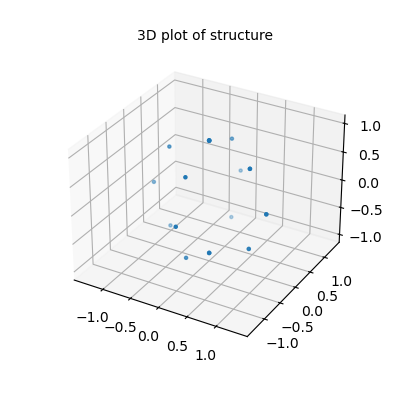

In [189]:
test1, test2, test3 = system_maker(3,8,1,50)
teset4 = projection_points(1,5)
plot_structure(teset4)

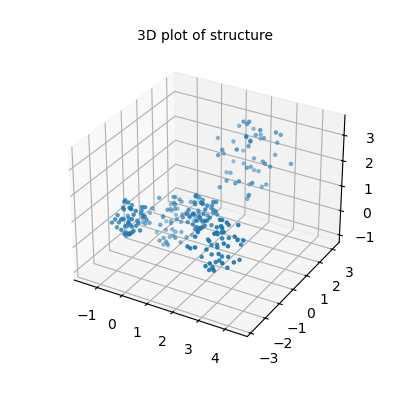

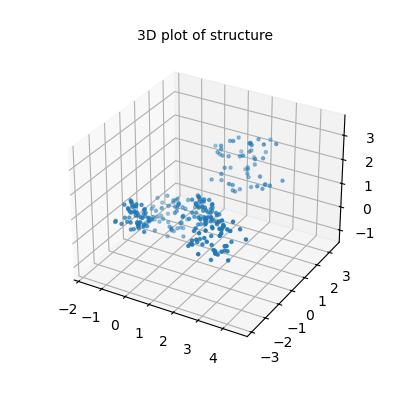

In [123]:
s1 = sphere(1,50)
a = sphere(3,50)
b= sphere(0.3,50)

s2 = transformer([2,2,2],a)
s3 = transformer([1.5,-0.5,1],b)
s4 = transformer([3,-2,1],s1)
s5 = transformer([-0.4,-2,1],b)
structure_sphere = np.concatenate((s1,s2,s3,s4,s5), axis = 0)
plot_structure(structure_sphere)

s1 = ellipsoid(1,50)
a = ellipsoid(3,50)
b= ellipsoid(0.3,50)

s2 = transformer([2,2,2],a)
s3 = transformer([1.5,-0.5,1],b)
s4 = transformer([3,-2,1],s1)
s5 = transformer([-0.4,-2,1],b)
structure_elips = np.concatenate((s1,s2,s3,s4,s5), axis = 0)

In [70]:
plt.clf()

In [245]:
#structure_sphere = sphere(1, 100)
#structure_elips = elipsoid(1,100)

#structure_sphere = points_remover(structure_sphere, 98)
#structure_elips = points_remover(structure_elips, 98)


projected_images_sphere = points_projection(structure_sphere, 20)
projected_images_eplis = points_projection(structure_elips, 20)
merged_projection = np.concatenate((projected_images_sphere, projected_images_eplis), axis=0)


label = label_making(0, projected_images_sphere)
label2 = label_making(1, projected_images_eplis)
label.extend(label2)
print(len(label))

800


In [296]:
#images_bw = image_projection(merged_projection, (32,32))

# Split data set using SKlearn
data_array = np.array(images_bw) 
labels_array = np.array(label)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_array, labels_array, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (12000, 32, 32)
Validation data shape: (3000, 32, 32)


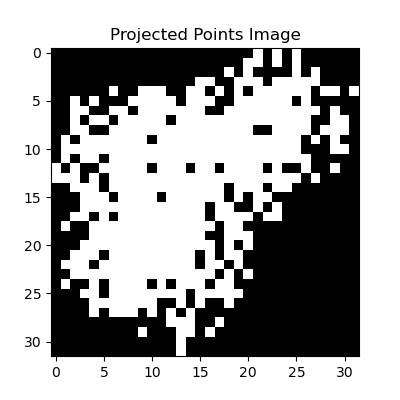

In [273]:
plt.clf()
plt.imshow(images_bw[20], cmap='gray')
plt.title('Projected Points Image')
plt.show()

In [18]:
images_grid = cluster_per_cell(merged_projection,(64,64), (32,32))

# Split data set using SKlearn
data_array = np.array(images_grid) 
labels_array = np.array(label)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_array, labels_array, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (640, 32, 32)
Validation data shape: (160, 32, 32)


In [297]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

In [298]:
# Instantiate the dataset
BATCH_SIZE = 32
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [299]:
print(f'Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...')

Length of train_dataloader: 375 batches of 32...


## Model

In [300]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 16 * 16, 2)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = self.fc1(x)
        return x

model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=2, bias=True)
)

In [301]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [302]:
# Example training loop with device
num_epochs = 5

for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)  # Send data to GPU and add channel dimension
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}')

print('Finished Training')

# Test model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)  # Send data to GPU and add channel dimension
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nAccuracy of the network on the validation images: {100 * correct / total}%')


# Calculate parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

Epoch 1, Loss: 0.7249421736399333
Epoch 2, Loss: 0.7179347132047017
Epoch 3, Loss: 0.7086318093935648
Epoch 4, Loss: 0.7031134901046753
Epoch 5, Loss: 0.6983750777244568
Finished Training

Accuracy of the network on the validation images: 49.03333333333333%
Total parameters: 8354


# Test 2

In [235]:
start = time.time()

# test1, test2, sphere_img, sphere_img2 = system_maker(20000,8,1,100,2,(64,64))
# test3, test4, ellips_img, ellips_img2 = system_maker2(20000,8,1,100,2,(64,64))

merged_projection = np.concatenate((sphere_img2, ellips_img2), axis=0)
images_bw = merged_projection

end = time.time()
# record time
creation_time = end - start

label = label_making(0, sphere_img2)
label2 = label_making(1, ellips_img2)
label.extend(label2)
#print(len(label))

#print(images_bw.shape)

# Split data set using SKlearn
data_array = np.array(images_bw) 
labels_array = np.array(label)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_array, labels_array, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


# Instantiate the dataset
BATCH_SIZE = 32
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...')

Training data shape: (128000, 64, 64)
Validation data shape: (32000, 64, 64)
Length of train_dataloader: 4000 batches of 32...


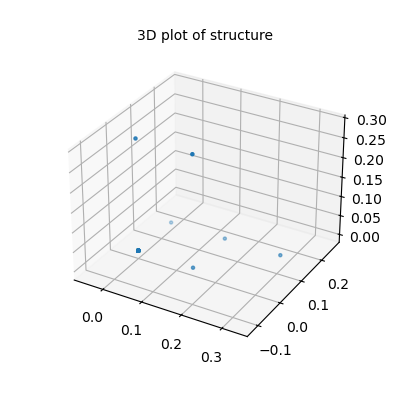

In [373]:
plt.clf()
plot_structure(sphere_img2[4001])

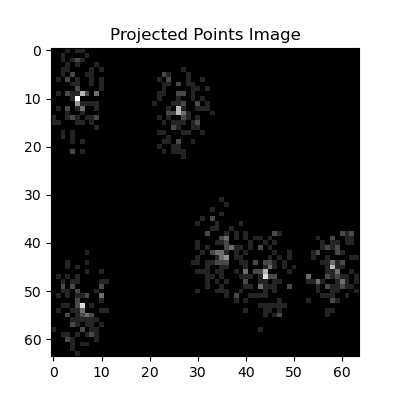

In [383]:
plt.clf()
# for i in test3:
#     plot_structure(i)
plt.imshow(sphere_img2[14069], cmap='gray')
plt.title('Projected Points Image')
plt.show()

In [405]:
# calculate size of output
# Tensor_size
w= h = 16
fw =fh = 2
p, s = [0,2]
print(w,h,fw,fh,p,s)

out_width = ((w - fw +2*p)/s) +1
out_height = ((h - fh +2*p)/s) +1
print(f'The output shape is {out_width} x {out_height}')

16 16 2 2 0 2
The output shape is 8.0 x 8.0


In [407]:
class ImprovedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedNet().to(device)


In [239]:

# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode='circular')
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(16 * 32 * 32, 2)

    
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         return x

# model = SimpleCNN()
# model.to(device)
# print('Model being used is SimpleCNN')



class newNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=1, padding_mode='circular')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4, stride=1, padding=1, padding_mode='circular')
        self.fc1 = nn.Linear(16 * 15 * 15, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = newNet()
model.to(device)
print('Model being used is newNet')

Model being used is newNet


In [160]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop with device
num_epochs = 10
train_losses = []
val_losses = []

start = time.time()
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)  # Send data to GPU and add channel dimension
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        
    #Calc avg training loss
    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_train_loss}')




    # Test model
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device).unsqueeze(1), labels.to(device)  # Send data to GPU and add channel dimension
            outputs = model(inputs)
            loss = criterion(outputs, labels)
    
            val_loss = loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_val_loss}')
    print(f'Accuracy of the network on the validation images: {100 * correct / total}%\n')
    
end = time.time()
training_time = end - start

# Calculate parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

print(f'System generation finished in {creation_time // 60:.0f} minutes {creation_time % 60:.0f} seconds {creation_time % 1 * 1000:.0f} milliseconds')
print(f'\nTraining & validation finished in {training_time // 60:.0f} minutes {training_time % 60:.0f} seconds {training_time % 1 * 1000:.0f} milliseconds')

Epoch 1, Loss: 0.6907565263807773
Epoch 1, Loss: 0.0006683525443077087
Accuracy of the network on the validation images: 60.053125%

Epoch 2, Loss: 0.459296912945807
Epoch 2, Loss: 0.00011604877561330795
Accuracy of the network on the validation images: 92.025%

Epoch 3, Loss: 0.12480259171058423
Epoch 3, Loss: 2.3255232721567156e-05
Accuracy of the network on the validation images: 97.015625%

Epoch 4, Loss: 0.06464621528147836
Epoch 4, Loss: 1.9934425130486488e-05
Accuracy of the network on the validation images: 98.2625%

Epoch 5, Loss: 0.04454038327891612
Epoch 5, Loss: 7.3492545634508135e-06
Accuracy of the network on the validation images: 98.684375%

Epoch 6, Loss: 0.036548762807351524
Epoch 6, Loss: 7.697488646954298e-06
Accuracy of the network on the validation images: 98.921875%

Epoch 7, Loss: 0.029183829116655034
Epoch 7, Loss: 6.884702481329441e-06
Accuracy of the network on the validation images: 98.909375%

Epoch 8, Loss: 0.024572665880411477
Epoch 8, Loss: 5.05672348663

In [212]:
# create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    # Put model in train mode
    model.train()
    
    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader, data batch
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device).unsqueeze(1), y.to(device)

        #1. Forward pass
        y_pred = model(X) #output model logits
        
        #2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        #3. Optimizer zero grad
        optimizer.zero_grad()

        #4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()

        #6. Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred) # total no correct divided by len of sample

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

# create test_step
def test_step(model:  torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    #Setup test loss and test accuract values
    test_loss, test_acc = 0, 0

    # Turn on inderence mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            #send data to target device
            X, y = X.to(device).unsqueeze(1), y.to(device)

            #1. Forward pass
            test_pred_logits = model(X)

            #2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            #3. Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    #Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss /  len(dataloader)
    test_acc = test_acc /  len(dataloader)
    return test_loss, test_acc


# Create train function
#1. Create a train function that takes in varius model parameters + optimizer + dataloaders
def train(model:torch.nn.Module,
          train_data: torch.utils.data.DataLoader,
          test_data: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10,
          device=device):

    #Create result dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # Loop through training and testing steps for x number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_data,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_data,
                                        loss_fn=loss_fn,
                                        device=device)
        #Print out what's happening
        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        #Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [241]:
# Set no of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model=model,
                     train_data=train_dataloader,
                     test_data=val_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=NUM_EPOCHS)
# End timer and print out time taken
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 0 | Train loss: 0.6743 | Train acc: 0.5904 | Test loss: 0.5873 | Test acc: 0.6987
Epoch: 1 | Train loss: 0.2627 | Train acc: 0.8929 | Test loss: 0.1131 | Test acc: 0.9569
Epoch: 2 | Train loss: 0.0899 | Train acc: 0.9667 | Test loss: 0.0780 | Test acc: 0.9677
Epoch: 3 | Train loss: 0.0625 | Train acc: 0.9770 | Test loss: 0.0579 | Test acc: 0.9782
Epoch: 4 | Train loss: 0.0463 | Train acc: 0.9834 | Test loss: 0.0446 | Test acc: 0.9846
Epoch: 5 | Train loss: 0.0379 | Train acc: 0.9866 | Test loss: 0.0367 | Test acc: 0.9866
Epoch: 6 | Train loss: 0.0317 | Train acc: 0.9891 | Test loss: 0.0418 | Test acc: 0.9838
Epoch: 7 | Train loss: 0.0273 | Train acc: 0.9908 | Test loss: 0.0339 | Test acc: 0.9876
Epoch: 8 | Train loss: 0.0242 | Train acc: 0.9918 | Test loss: 0.0270 | Test acc: 0.9902
Epoch: 9 | Train loss: 0.0201 | Train acc: 0.9929 | Test loss: 0.0426 | Test acc: 0.9856
Epoch: 10 | Train loss: 0.0160 | Train acc: 0.9947 | Test loss: 0.0224 | Test acc: 0.9924
Epoch: 11 | Train lo

In [409]:
# Set no of epochs
NUM_EPOCHS = 15

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model=model,
                     train_data=train_dataloader,
                     test_data=val_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=NUM_EPOCHS)
# End timer and print out time taken
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 0 | Train loss: 0.1648 | Train acc: 0.9259 | Test loss: 0.0518 | Test acc: 0.9795
Epoch: 1 | Train loss: 0.0510 | Train acc: 0.9817 | Test loss: 0.0251 | Test acc: 0.9911
Epoch: 2 | Train loss: 0.0372 | Train acc: 0.9873 | Test loss: 0.0219 | Test acc: 0.9918
Epoch: 3 | Train loss: 0.0288 | Train acc: 0.9904 | Test loss: 0.0193 | Test acc: 0.9923
Epoch: 4 | Train loss: 0.0247 | Train acc: 0.9916 | Test loss: 0.0182 | Test acc: 0.9931
Epoch: 5 | Train loss: 0.0214 | Train acc: 0.9929 | Test loss: 0.0131 | Test acc: 0.9954
Epoch: 6 | Train loss: 0.0178 | Train acc: 0.9940 | Test loss: 0.0138 | Test acc: 0.9946
Epoch: 7 | Train loss: 0.0153 | Train acc: 0.9951 | Test loss: 0.0091 | Test acc: 0.9970
Epoch: 8 | Train loss: 0.0125 | Train acc: 0.9959 | Test loss: 0.0102 | Test acc: 0.9964
Epoch: 9 | Train loss: 0.0115 | Train acc: 0.9962 | Test loss: 0.0085 | Test acc: 0.9974
Epoch: 10 | Train loss: 0.0092 | Train acc: 0.9971 | Test loss: 0.0072 | Test acc: 0.9979
Epoch: 11 | Train lo

In [243]:
# Get model result keys
from typing import Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """ Plots training curves of a result dictionary """
    # Get loss value of result dictionary(training and testing)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get accuracy values of the result dictionary (training and testing)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    #Figure out no of epochs
    epochs = range(len(results["train_loss"]))
    
    #Setup plot
    plt.figure(figsize=(8,4))

    #plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="Train_loss")
    plt.plot(epochs, test_loss, label="Test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    #plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="Train_accuracy")
    plt.plot(epochs, test_accuracy, label="Test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

    plt.savefig('Loss_acc3.png')

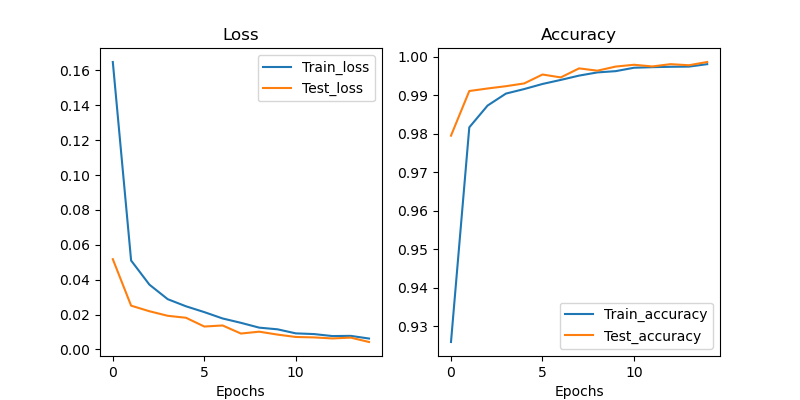

In [411]:
plot_loss_curves(model_results)

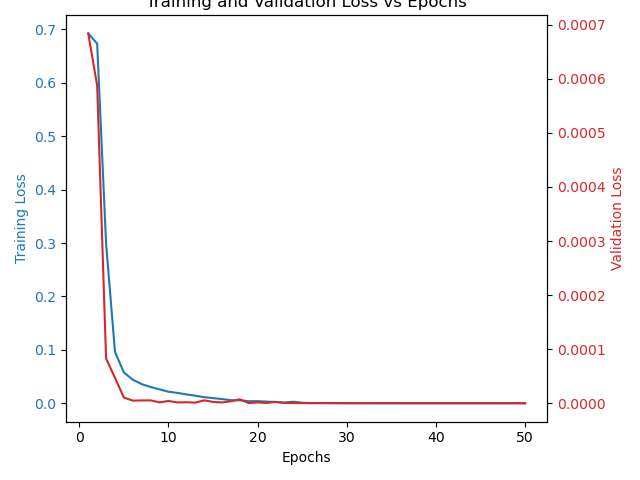

In [154]:
plt.figure(figsize=(4,4))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(range(1, num_epochs + 1), train_losses, color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Validation Loss', color=color)  # we already handled the x-label with ax1
ax2.plot(range(1, num_epochs + 1), val_losses, color=color, label='Validation Loss')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training and Validation Loss vs Epochs')
plt.show()

In [132]:
combined = np.hstack((train_losses, val_losses))
filename = f'train_val_loss{multi}.txt'
np.savetxt(filename, combined,delimiter=',', fmt='%f' )